### Look at: what is the relationship between residual R^2 and partial R^2?
Would expect them to be equal, if not very correlated

### CURRENT STATUS:
- Getting negative partial R^2s, implying R^2 of model without values > R^2 model with values. Don't know how this is possible. 
- In the full regression case also sometimes getting negative scores. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [3]:
positions = spike_utils.get_unit_positions(sessions)

### Load residual models

In [4]:
fb_type = "Response"

def load_glm(session, res_name):
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["TimeIdxs"] = (res["TimeBins"] * 20).astype(int)
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res


def get_residual_glm_res(session):
    res_name = f"{session}_glm_{fb_type}_residual_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    res = load_glm(session, res_name)
    res = res.rename(columns={"score": "residual_score"})
    return res

In [5]:
residual_glm_res = pd.concat(sessions.apply(lambda x: get_residual_glm_res(x.session_name), axis=1).values)

In [6]:
merged = pd.merge(residual_glm_res, positions, on="PseudoUnitID")
merged[merged.residual_score > 0.1].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
anterior_cingulate_gyrus (ACgG)        1
basal_ganglia (BG)                     7
lateral_prefrontal_cortex (lat_PFC)    4
motor_cortex (motor)                   1
Name: PseudoUnitID, dtype: int64

### Load and calculate partial r^2

In [7]:
def get_additional_score(session):
    with_vals_path = f"{session}_glm_RPEGroup_normal_fr_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"
    with_vals_res = load_glm(session, with_vals_path)
    with_vals_res = with_vals_res.rename(columns={"score": "with_vals_score"})
    coefs = [col for col in with_vals_res.columns if "_coef" in col]

    without_vals_path = f"{session}_glm_{MODE}_{INTERVAL_SIZE}_{MODEL}_feature_rpe_interaction.pickle"
    without_vals_res = load_glm(session, without_vals_path)
    without_vals_res = without_vals_res.rename(columns={"score": "without_vals_score"})

    coefs = [col for col in without_vals_res.columns if "_coef" in col]
    merged = pd.merge(with_vals_res, without_vals_res, on=["PseudoUnitID", "TimeIdxs"])
    merged["additional_score"] = 1 - (1 - merged["with_vals_score"]) / (1 - merged["without_vals_score"])
    # merged["additional_score"] = 
    return merged

In [8]:
partial_reses = pd.concat(sessions.apply(lambda x: get_additional_score(x.session_name), axis=1).values)

In [9]:
merged = pd.merge(partial_reses, residual_glm_res, on=["PseudoUnitID", "TimeIdxs"])
pos_merged = merged[merged.additional_score > 0]

In [10]:
len(pos_merged.PseudoUnitID.unique())

754

In [11]:
print(np.corrcoef(pos_merged.additional_score, pos_merged.residual_score)[0, 1])

0.7400112448441966


Text(0, 0.5, 'residual score')

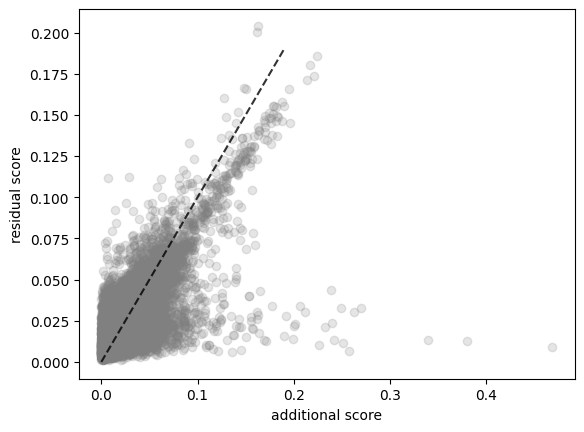

In [12]:
fig, ax = plt.subplots()
ax.scatter(pos_merged.additional_score, pos_merged.residual_score, alpha=0.2, color="gray")
ax.plot(np.arange(0, 0.2, 0.01), np.arange(0, 0.2, 0.01), linestyle="--", color="black", alpha=0.8)
ax.set_xlabel("additional score")
ax.set_ylabel("residual score")


In [13]:
pos_res = pd.merge(residual_glm_res, positions, on="PseudoUnitID")

In [14]:
# good_units = pos_res.sort_values(by="residual_score", ascending=False)[:200].PseudoUnitID.unique()

In [15]:
# positions[positions.PseudoUnitID.isin(good_units)].manual_structure.unique()

In [20]:
good_units = pos_res[pos_res.residual_score > 0.1].PseudoUnitID.unique()

In [19]:
pos_res[pos_res.residual_score > 0.05].groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
amygdala (Amy)                         12
anterior_cingulate_gyrus (ACgG)        19
basal_ganglia (BG)                     16
inferior_parietal_lobule (IPL)          2
inferior_temporal_cortex (ITC)         17
lateral_and_ventral_pallium (LVPal)    12
lateral_prefrontal_cortex (lat_PFC)    49
motor_cortex (motor)                   20
orbital_frontal_cortex (OFC)            5
posterior_medial_cortex (PMC)           8
superior_parietal_lobule (SPL)          2
unknown                                 2
Name: PseudoUnitID, dtype: int64

In [20]:
# good_units = pos_res[(pos_res.structure_level3 == "hippocampal_formation (HF)")]
# good_units = good_units.sort_values(by="residual_score", ascending=False)[:20].PseudoUnitID.unique()

In [53]:
good_units = pos_res[
    (pos_res.residual_score > 0.05) & 
    (pos_res.structure_level2 == "basal_ganglia (BG)")
].PseudoUnitID.unique()

In [21]:
good_units

array([    2018070904,     2018070910,     2018070943,     2018091832,
           2018080100,     2018080115, 20180725000116,     2018080800,
           2018070535,     2018100400,     2018091710,     2018071238,
           2018071249])

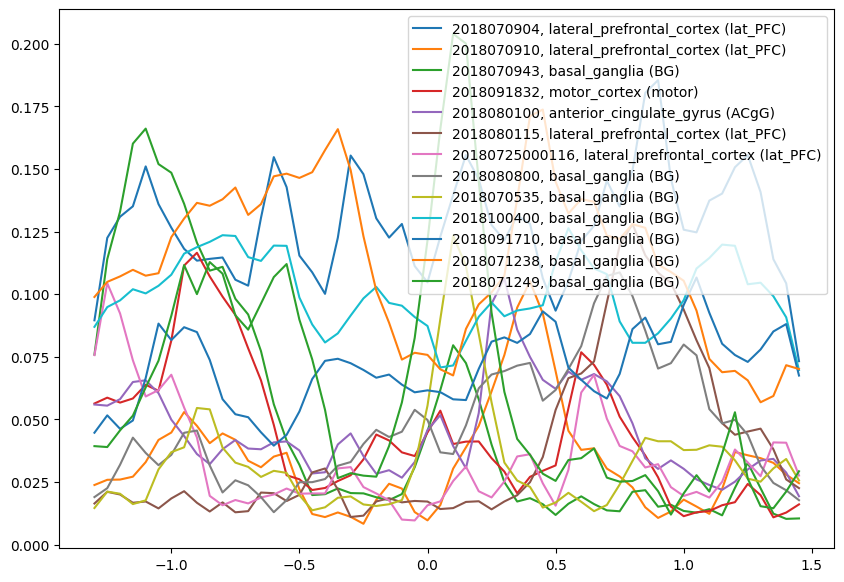

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
for unit in good_units:
    unit_res = pos_res[pos_res.PseudoUnitID == unit]
    structure =  unit_res.structure_level2.values[0]
    # color = 'red' if structure == "basal_ganglia (BG)" else 'blue'
    ax.plot(unit_res.TimeBins - 1.3, unit_res.residual_score, label=f"{unit}, {structure}")
ax.legend()

In [39]:
unit_res = pos_res[pos_res.PseudoUnitID == 2018070922]

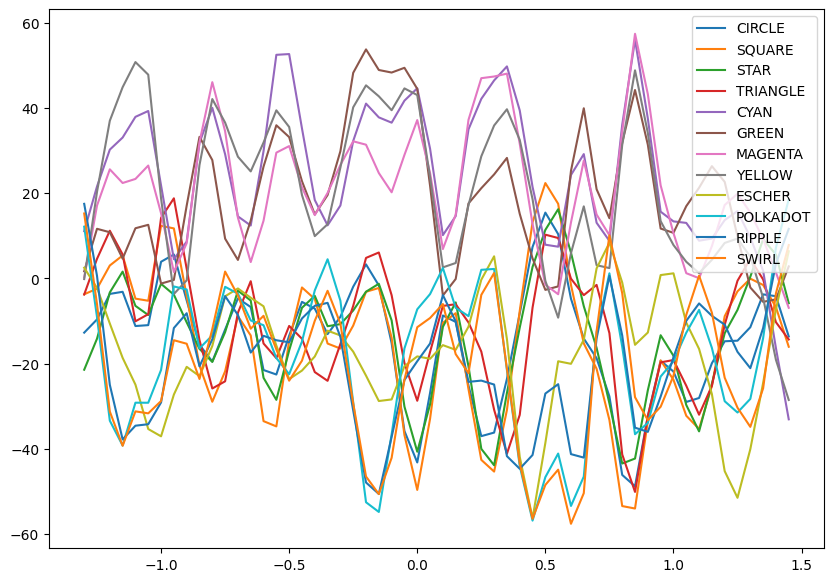

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
for feat in FEATURES:
    ax.plot(unit_res.TimeBins - 1.3, unit_res[feat + "Value_coef"], label=feat)
ax.legend()

In [35]:
def calc_normed(group):
    session = group.name
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)

    return glm_utils.calc_normalized_value_coefs(group, beh)

normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()

/tmp/ipykernel_2416663/2337501274.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  normed = pos_res.groupby("session_x").apply(calc_normed).reset_index()


In [49]:
normed[normed.PseudoUnitID == 2018070922].structure_level3

1232    striatum (Str)
1233    striatum (Str)
1234    striatum (Str)
1235    striatum (Str)
1236    striatum (Str)
1237    striatum (Str)
1238    striatum (Str)
1239    striatum (Str)
1240    striatum (Str)
1241    striatum (Str)
1242    striatum (Str)
1243    striatum (Str)
1244    striatum (Str)
1245    striatum (Str)
1246    striatum (Str)
1247    striatum (Str)
1248    striatum (Str)
1249    striatum (Str)
1250    striatum (Str)
1251    striatum (Str)
1252    striatum (Str)
1253    striatum (Str)
1254    striatum (Str)
1255    striatum (Str)
1256    striatum (Str)
1257    striatum (Str)
1258    striatum (Str)
1259    striatum (Str)
1260    striatum (Str)
1261    striatum (Str)
1262    striatum (Str)
1263    striatum (Str)
1264    striatum (Str)
1265    striatum (Str)
1266    striatum (Str)
1267    striatum (Str)
1268    striatum (Str)
1269    striatum (Str)
1270    striatum (Str)
1271    striatum (Str)
1272    striatum (Str)
1273    striatum (Str)
1274    striatum (Str)
1275    str